## Интеллектуальный анализ данных – весна 2022
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html). 

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [170]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования.

In [171]:
X.isna().sum()
#категориальных нет

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

In [172]:
from sklearn.model_selection import train_test_split

In [173]:
np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3)
X_train.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
80,12.00,0.92,2.00,19.0,86.0,2.42,2.26,0.30,1.43,2.50,1.380,3.12,278.0
26,13.39,1.77,2.62,16.1,93.0,2.85,2.94,0.34,1.45,4.80,0.920,3.22,1195.0
115,11.03,1.51,2.20,21.5,85.0,2.46,2.17,0.52,2.01,1.90,1.710,2.87,407.0
177,14.13,4.10,2.74,24.5,96.0,2.05,0.76,0.56,1.35,9.20,0.610,1.60,560.0
70,12.29,1.61,2.21,20.4,103.0,1.10,1.02,0.37,1.46,3.05,0.906,1.82,870.0


**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [174]:
from sklearn.preprocessing import StandardScaler

In [175]:
scaler = StandardScaler()
X_train_transformed= scaler.fit_transform(X_train)
X_train_transformed= pd.DataFrame(X_train_transformed)
X_test_transformed = scaler.transform(X_test)
X_test_transformed = pd.DataFrame(X_test_transformed)
X_train_transformed.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-1.092051,-1.178305,-1.242747,-0.059813,-0.869332,0.211180,0.181163,-0.456186,-0.433811,-1.001982,1.613321,0.792520,-1.360467
1,0.674558,-0.397907,1.100149,-1.081280,-0.438728,0.890954,0.882462,-0.161334,-0.398411,-0.047303,-0.220887,0.943503,1.684296
2,-2.324865,-0.636617,-0.486974,0.820763,-0.930847,0.274415,0.088344,1.165500,0.592774,-1.251028,2.929166,0.415062,-0.932142
3,1.615056,1.741300,1.553612,1.877453,-0.254184,-0.373741,-1.365822,1.460352,-0.575409,1.779038,-1.456984,-1.502427,-0.424128
4,-0.723478,-0.544806,-0.449186,0.433310,0.176420,-1.875568,-1.097678,0.059805,-0.380711,-0.773689,-0.276711,-1.170263,0.605181


In [176]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle

In [177]:
for k in [1, 3, 5, 10, 15, 25]:
    y_predicted_train = KNeighborsClassifier(n_neighbors=k).fit(X_train_transformed[[0, 4]], y_train).predict(X_train_transformed[[0, 4]])
    y_predicted_test = KNeighborsClassifier(n_neighbors=k).fit(X_train_transformed[[0, 4]], y_train).predict(X_test_transformed[[0, 4]])
    train_accuracy = np.mean(y_predicted_train==y_train)
    test_accuracy = np.mean(y_predicted_test==y_test)
    print("NN:", "%.2f" % (k), "Train:", "%.2f" % (train_accuracy), "Test:", "%.2f" % (test_accuracy))

NN: 1.00 Train: 1.00 Test: 0.64
NN: 3.00 Train: 0.85 Test: 0.65
NN: 5.00 Train: 0.83 Test: 0.67
NN: 10.00 Train: 0.81 Test: 0.67
NN: 15.00 Train: 0.75 Test: 0.69
NN: 25.00 Train: 0.74 Test: 0.65


### ПРИМЕР ВЫВОДА ###
NN 	 Train 	 Test
1 	 1.0 	 0.56
3 	 0.83 	 0.61
5 	 0.81 	 0.63
10 	 0.79 	 0.54
15 	 0.74 	 0.57
25 	 0.76 	 0.56


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/). 

In [20]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [178]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов. 
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново. 
6. Построение графика может занять некоторое время – придётся немного подождать!

In [179]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

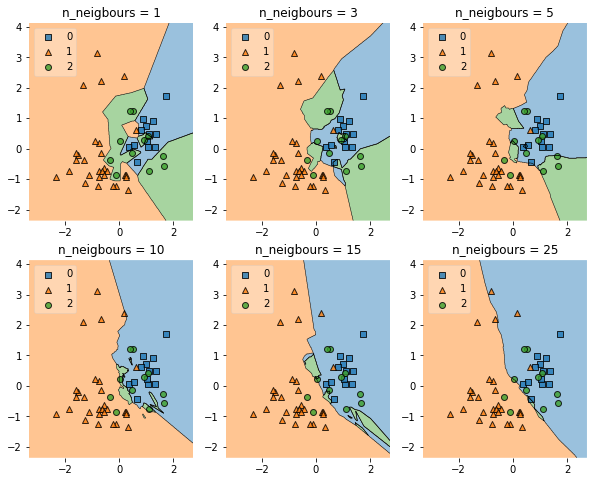

In [180]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = KNeighborsClassifier(n_neighbors=3)
clf3 = KNeighborsClassifier(n_neighbors=5)
clf4 = KNeighborsClassifier(n_neighbors=10)
clf5 = KNeighborsClassifier(n_neighbors=15)
clf6 = KNeighborsClassifier(n_neighbors=25)

gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(10,8))

labels = ['n_neigbours = 1', 'n_neigbours = 3', 'n_neigbours = 5', 'n_neigbours = 10', 'n_neigbours = 15', 'n_neigbours = 25']


for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5, clf6], labels, itertools.product([0, 1], [0, 1, 2])):
    clf.fit(X_train_transformed[[0, 4]], y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_transformed[[0, 4]].to_numpy(), y=y_train, clf=clf, legend=2)
    plt.title(lab)

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности.

In [168]:
#Мне кажется, что лучшего всего использовать число соседей равное k=5, не смотря на то, что лучшая точность на тестовой выборке была при k=15,
#потому что при k=5 решающая поверхтность выглядит лучше всего (наиболее гладко и не пропадает 3ий класс)

### Задание 2: Обученная машина.

В этом задании мы рассмотрим упрощённую идею того, как метод ближайших соседей можно применить при моделировании движения робота. 

Рассмотрим робота на дискретной двумерной плоскости, который за каждый момент дискретного времени может передвинуться на одну позицию вправо, влево, вверх или вниз. На плоскости разбросаны метки одного из четырёх классов, анализируя которые робот может (но не обязан) корректировать своё перемещение. Пусть метки класса 0 соответствуют сигналу переместиться вправо, метки класса 1 – влево, класса 2 – вверх, класса 3 – вниз. 

Передвижение робота осуществляется по следующему правилу: с вероятностью 0.2 робот передвинется вправо, и с вероятностью 0.8 – оценит, метки какого класса преобладают среди `k` его ближайших соседей, и передвинется в направлении этого доминирующего класса. 

Для лучшего понимания происходящего изобразим возможное положение робота и меток:

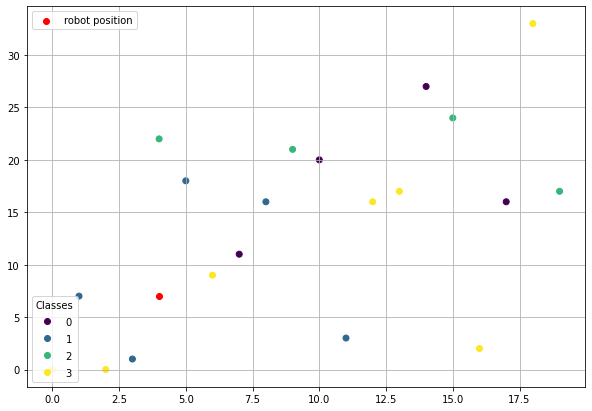

In [181]:
np.random.seed(12345)
x = np.arange(20)
landmarks = x + np.round(np.random.normal(2, 8, 20)) # сгенерируем случайные метки
random_classes = np.random.randint(0, 4, 20)

fig, ax = plt.subplots(figsize = (10, 7))
scatter = ax.scatter(x, landmarks, c = random_classes)
ax.scatter(4, 7, c = 'r', marker = 'o', label = 'robot position')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc = "lower left", title = "Classes")
ax.add_artist(legend1)

plt.plot()
_ = plt.legend()
_ = plt.grid()

На следующем шаге робот передвинется на 1 либо вправо, либо в направлении, которое указывают ближайшие соседи.

**Задача 2.1 (1.5 балла)** Реализуйте класс, который задаёт описанное поведение робота, используя шаблон ниже:
1. Определите атрибуты `trajectory` (переменная для хранения истории перемещения робота в виде последовательности точек с двумя координатами) и `knn` (обученный kNN классификатор, который по позиции метки предсказывает её класс).
2. Определите метод `move()`: рассчитайте новое положение робота по правилам выше и добавьте её в историю перемещений. Подсказка: исходы можно интерпретировать как результаты подбрасывания монетки с вероятностью орла, равной 0.2. Для моделирования такого подбрасывания можно использовать, например, `np.random.binomial()` с правильными параметрами. 

In [182]:
from sklearn.neighbors import KNeighborsClassifier

In [183]:
class MobileRobot():
    
    def __init__(self, k, initial_position, landmarks, classes):
        '''
        Attributes:
        ------
        k: int
            Number of neighbours
            
        initial_position: ndarray
            Initial position of the robot as a point, e.g. (-1, 1)
            
        landmarks: ndarray
            numpy array of shape (n_landmarks, 2) with the euclidean positions of points
        
        classes: ndarray
            numpy array of shape (n_landmarks, ) with class of landmark for each point in landmarks
        
        '''
        self.number_of_neighbours = k
        self.initial_position = initial_position
        self.landmarks = landmarks
        self.classes = classes
        
        
        
        # Store the history of movements
        self.trajectory = initial_position.reshape(-1, 2) # <ВАШ КОД ЗДЕСЬ>
        
        # kNN Classifier for determining the classes of landmarks
        self.knn = KNeighborsClassifier(n_neighbors=k).fit(landmarks, classes) # <ВАШ КОД ЗДЕСЬ>
        
        # Mapping between classes of points and movements
        self.mapping = {0: np.array([1, 0]), 
                        1: np.array([-1, 0]),
                        2: np.array([0, 1]),
                        3: np.array([0, -1])}
        
    def move(self):
        '''
        Calculate new position of the robot and add it to the history
        '''
        s = np.random.binomial(1, .2)
        if s == 1:
            self.trajectory = np.append(self.trajectory, np.add(self.trajectory[-1], np.array([1, 0])))
        else:
            self.trajectory = np.append(self.trajectory, np.add(self.trajectory[-1], self.mapping[int(self.knn.predict(self.trajectory[-1].reshape(-1, 2)))]))
        self.trajectory = self.trajectory.reshape(-1, 2)
        # <ВАШ КОД ЗДЕСЬ>

**Задача 2.2 (0.5 балла)** Дополните функцию `conduct_experiment`: определите переменную `traj` так, чтобы она содержала историю перемещения робота в виде двумерного массива numpy, в котором столбцы соответствуют координатам x и y соответствующей позиции.

In [184]:
def conduct_experiment(x,
                       mean = 0,
                       std = 2, 
                       n_movements = 10, 
                       k = 3, 
                       initial_position = np.array([10, 20])):
    
    np.random.seed(12345)
    # Generate random landmarks
    landmarks = np.vstack((x, x + np.round(np.random.normal(mean, std, len(x))))).T
    
    # Generate random classes of landmarks
    classes = np.random.randint(0, 4, size = len(x))
    
    # Conduct experiment
    robot = MobileRobot(k, initial_position, landmarks, classes)
    
    for n in range(n_movements):
        robot.move()
    
    fig, ax = plt.subplots(figsize = (10, 8))
    scatter = ax.scatter(landmarks[:, 0], landmarks[:, 1], c = classes)
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="classes")
    ax.add_artist(legend1)
    
    traj = robot.trajectory
    # <ВАШ КОД ЗДЕСЬ>
    ax.plot(traj[:, 0], traj[:, 1], 
               c = 'r', marker = 'o', label = 'robot position')

    plt.plot()
    _ = plt.legend()
    _ = plt.grid()

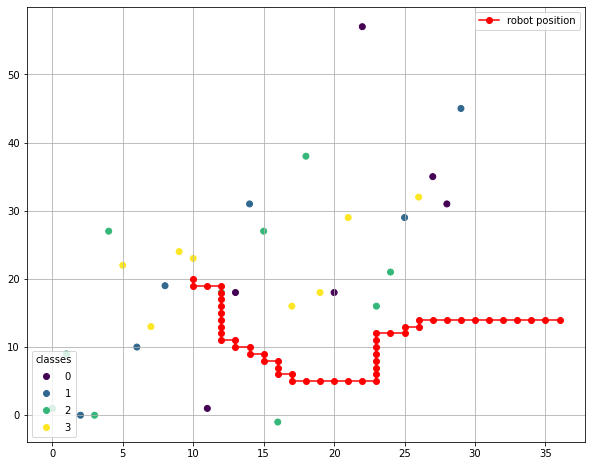

In [185]:
x = np.arange(30)
conduct_experiment(x, mean = 3, std = 10, k = 7, n_movements = 50)

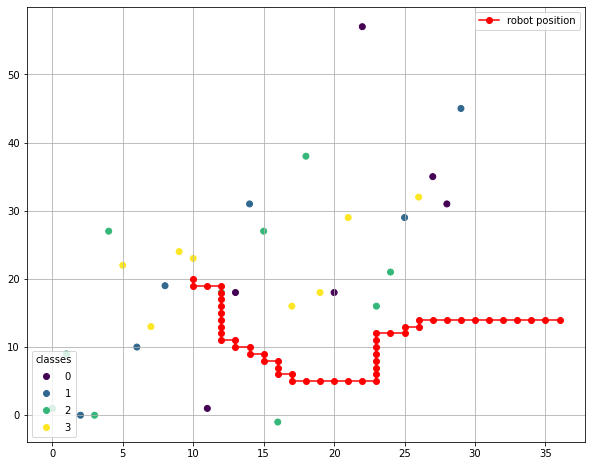

In [186]:
x = np.arange(30)
conduct_experiment(x, mean = 3, std = 10, k = 7, n_movements = 50)

**Задача 2.3 (1 балл)** Как число соседей влияет на траекторию движения робота в нашем эксперименте? Постройте четыре графика с различным числом соседей на ваш выбор. А что было бы в случае, если классы назначаются меткам не случайно, а осмысленно? 

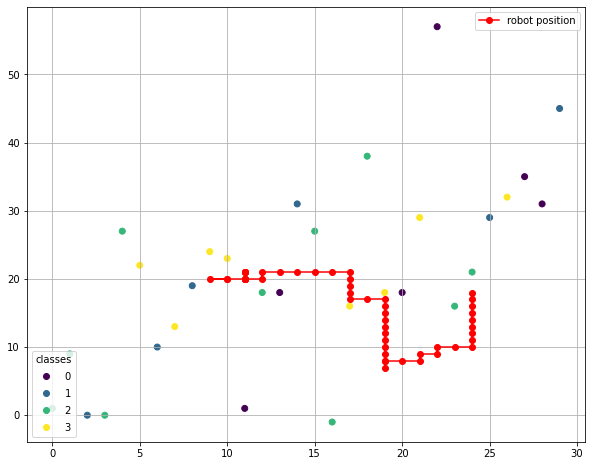

In [187]:
conduct_experiment(x, mean = 3, std = 10, k = 1, n_movements = 50)

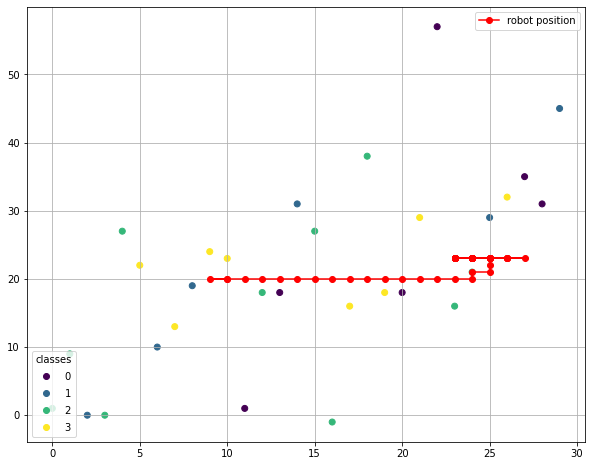

In [188]:
conduct_experiment(x, mean = 3, std = 10, k = 2, n_movements = 50)

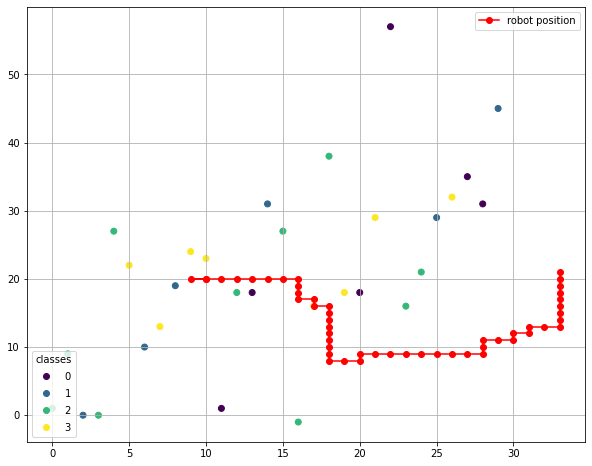

In [189]:
conduct_experiment(x, mean = 3, std = 10, k = 3, n_movements = 50)

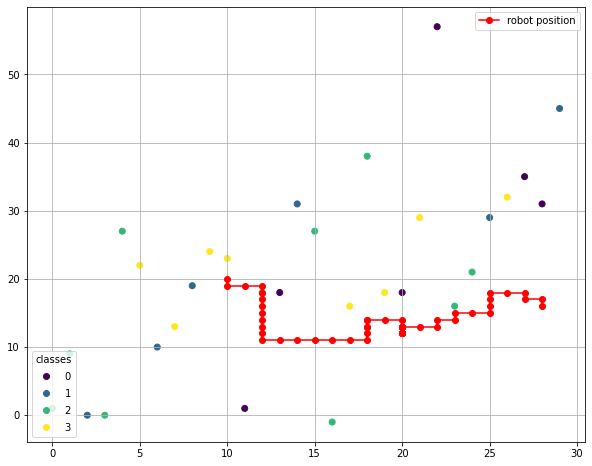

In [190]:
conduct_experiment(x, mean = 3, std = 10, k = 10, n_movements = 50)

In [191]:
#закономерности при изменении k не вижу. Если бы назначали осмысленно, возможно было бы осмысленное движение: например, если вокруг начальной позиции расположить много точек одного класса, то робот будет в основном двигаться в этом нарпавлении (при нужном k)

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [192]:
data = pd.read_csv("C:/Users/User/Майнор ИАД/2 семестр/Домашки/ДЗ_4/diamonds.csv")
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.1 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их. 

In [193]:
data.isna().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

**Задача 3.2 (0.1 балла)** Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [194]:
#таких нет

**Задача 3.3 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [195]:
import seaborn as sns

<AxesSubplot:>

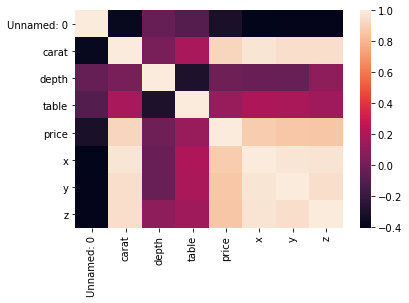

In [196]:
NumericData = data._get_numeric_data()
sns.heatmap(NumericData.corr())

**Задача 3.4 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [197]:
data = pd.get_dummies(data, columns=['color'])
data = pd.get_dummies(data, columns=['cut'])
data = pd.get_dummies(data, columns=['clarity'])
data.head()

,Unnamed: 0,carat,depth,table,price,x,y,z,color_D,color_E,...,cut_Premium,cut_Very Good,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,1,0.23,61.5,55.0,326,3.95,3.98,2.43,0,1,...,0,0,0,0,0,1,0,0,0,0
1,2,0.21,59.8,61.0,326,3.89,3.84,2.31,0,1,...,1,0,0,0,1,0,0,0,0,0
2,3,0.23,56.9,65.0,327,4.05,4.07,2.31,0,1,...,0,0,0,0,0,0,1,0,0,0
3,4,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,...,1,0,0,0,0,0,0,1,0,0
4,5,0.31,63.3,58.0,335,4.34,4.35,2.75,0,0,...,0,0,0,0,0,1,0,0,0,0


**Задача 3.5 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3.

In [198]:
y = data.price

In [199]:
data = data.drop(["Unnamed: 0"], axis=1)
X = data.drop("price", axis = "columns")

In [200]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3)
X_train.head()

,carat,depth,table,x,y,z,color_D,color_E,color_F,color_G,...,cut_Premium,cut_Very Good,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
10041,0.26,61.9,56.0,4.07,4.10,2.53,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
28892,0.30,61.8,58.0,4.32,4.36,2.68,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
43050,0.52,60.7,58.0,5.23,5.18,3.16,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
38863,0.40,61.3,56.0,4.76,4.73,2.91,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
26296,1.55,62.5,57.0,7.35,7.33,4.59,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


**Задача 3.6 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [201]:
scaler = StandardScaler()
X_train_transformed= scaler.fit_transform(X_train)
X_train_transformed= pd.DataFrame(X_train_transformed)
X_test_transformed = scaler.transform(X_test)
X_test_transformed = pd.DataFrame(X_test_transformed)
X_train_transformed.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,-1.137193,0.113010,-0.671049,-1.486621,-1.473407,-1.452897,-0.379058,-0.468447,-0.460384,1.948355,...,-0.586342,1.836069,-0.113832,-0.185624,-0.573307,-0.448009,2.369747,-0.544737,-0.265692,-0.321041
1,-1.052944,0.042804,0.234736,-1.263568,-1.239615,-1.237089,-0.379058,-0.468447,-0.460384,-0.513253,...,1.705490,-0.544642,-0.113832,-0.185624,-0.573307,-0.448009,-0.421986,-0.544737,3.763760,-0.321041
2,-0.589571,-0.729460,0.234736,-0.451655,-0.502270,-0.546504,2.638118,-0.468447,-0.460384,-0.513253,...,1.705490,-0.544642,-0.113832,-0.185624,1.744267,-0.448009,-0.421986,-0.544737,-0.265692,-0.321041
3,-0.842320,-0.308225,-0.671049,-0.870995,-0.906911,-0.906184,-0.379058,-0.468447,2.172101,-0.513253,...,-0.586342,-0.544642,-0.113832,-0.185624,-0.573307,-0.448009,2.369747,-0.544737,-0.265692,-0.321041
4,1.579855,0.534244,-0.218156,1.439836,1.431012,1.510864,-0.379058,-0.468447,-0.460384,1.948355,...,-0.586342,-0.544642,-0.113832,-0.185624,-0.573307,-0.448009,-0.421986,-0.544737,-0.265692,3.114865


**Задача 3.7 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [202]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

In [203]:
model = LinearRegression()
model.fit(X_train_transformed, y_train)
y_pred_train = model.predict(X_train_transformed)
y_pred_test = model.predict(X_test_transformed)

print("The Mean Square Error on train is: ", mean_squared_error(y_train,y_pred_train))
print("The Mean Square Error on test is: ", mean_squared_error(y_test,y_pred_test))

The Mean Square Error on train is:  1251951.6986477154
The Mean Square Error on test is:  1289781.4477920276


**Задача 3.8 (0.2 балла)** Изучите документацию модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [204]:
model.coef_

array([ 5.46172684e+03, -7.99021907e+01, -5.66908292e+01, -1.20149790e+03,
       -2.71441286e+01, -4.49377929e+01, -2.61196665e+15, -3.02738191e+15,
       -2.99365979e+15, -3.20146872e+15, -2.86905833e+15, -2.40509957e+15,
       -1.71445176e+15, -1.96158144e+14, -3.34072086e+14, -5.72041167e+14,
       -5.10199290e+14, -4.91151945e+14,  7.61973412e+13,  1.21671431e+14,
        2.92572041e+14,  2.52996469e+14,  2.42880461e+14,  2.84839988e+14,
        1.68275348e+14,  1.97344562e+14])

In [205]:
for i in range(len(X.columns)):
    if abs(model.coef_[i]) >= 10 * np.median(model.coef_):
        print(X.columns[i])

carat
depth
table
x
y
z
color_D
color_E
color_F
color_G
color_H
color_I
color_J
cut_Fair
cut_Good
cut_Ideal
cut_Premium
cut_Very Good
clarity_I1
clarity_IF
clarity_SI1
clarity_SI2
clarity_VS1
clarity_VS2
clarity_VVS1
clarity_VVS2


**Задача 3.9 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом. 

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией. 

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [206]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [207]:
ridge = Ridge(alpha=10)
ridge.fit(X_train_transformed, y_train)
ridge.coef_

array([ 5.36980602e+03, -7.18059683e+01, -5.60945822e+01, -1.01422038e+03,
       -9.58133036e+01, -7.33206780e+01,  2.10325632e+02,  1.54328129e+02,
        1.40240788e+02,  6.07914675e+01, -1.33495501e+02, -2.57864112e+02,
       -3.66200834e+02, -1.23768753e+02, -4.04633156e+01,  5.72399774e+01,
        1.44543468e+01, -4.72828753e+00, -4.46256862e+02,  2.31696197e+02,
       -1.54989200e+02, -4.93732944e+02,  1.99908307e+02,  1.01213522e+02,
        2.47069210e+02,  2.89401636e+02])

In [208]:
lasso = Lasso(alpha=10)
lasso.fit(X_train_transformed, y_train)
lasso.coef_

array([ 4.95816433e+03, -4.18415960e+01, -4.31314250e+01, -7.07957284e+02,
       -0.00000000e+00, -8.23872033e+01,  1.43338923e+02,  7.98946542e+01,
        6.57466271e+01, -0.00000000e+00, -1.80415543e+02, -2.90600491e+02,
       -3.85718608e+02, -1.23235551e+02, -4.04268033e+01,  4.89538923e+01,
        0.00000000e+00, -3.88406382e+00, -4.61342823e+02,  1.80346680e+02,
       -2.60314932e+02, -5.75250526e+02,  9.93732137e+01, -0.00000000e+00,
        1.80310223e+02,  2.11886468e+02])

In [209]:
#веса уменьшились сильно, проблема мультиколлинеарности в задаче была ощутимой. Что логично, потому что количество карат в бриллианте сильно зависит от его размеров. Более того, размеры зависят друг от друга, так как бриллианты в основном напоминают шары по форме (вытянутые, продолговатые бриллианты никто не делает)

**Задача 3.10 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов. 

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

In [210]:
alphas = [0.1, 1, 10, 100, 200]
coeffs_ridge = []
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_transformed, y_train)
    coeffs_ridge.append(np.linalg.norm(ridge.coef_))
coeffs_ridge

[5682.499657268827,
 5670.605739557643,
 5561.676317463076,
 4822.74579264879,
 4289.948634602847]

In [211]:
coeffs_lasso = []
for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train_transformed, y_train)
    coeffs_lasso.append(np.linalg.norm(lasso.coef_))
coeffs_lasso

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105599435.54217911, tolerance: 26041259.520984087
  model = cd_fast.enet_coordinate_descent(


[5687.56538062442,
 5633.909139944369,
 5112.981471213609,
 3969.5112550846306,
 3656.7878942914303]

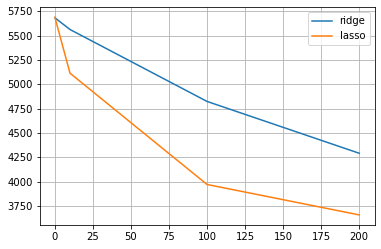

In [212]:
plt.plot(alphas, coeffs_ridge, label="ridge")
plt.plot(alphas, coeffs_lasso, label="lasso")
plt.legend(loc='upper right')
plt.grid()

In [213]:
#lasso работает гораздо агрессивнее, даже обнуляя некоторые признаки, поэтому с ее помощью проще отобрать нужные

**Задача 3.11 (0.5 балла)** 
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке. 

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`. 

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество. 

In [214]:
from sklearn.linear_model import LassoCV

In [215]:
lasso = LassoCV(cv=5, alphas=alphas).fit(X_train_transformed, y_train)
pd.DataFrame(lasso.mse_path_).mean(axis=1)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44822022.8571949, tolerance: 21173460.764760647
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2676689112.228384, tolerance: 21173460.764760647
  model = cd_fast.enet_coordinate_descent_gram(


0    1.924264e+06
1    1.513477e+06
2    1.271461e+06
3    1.262026e+06
4    1.268590e+06
dtype: float64

In [216]:
lasso.alphas_

array([2.e+02, 1.e+02, 1.e+01, 1.e+00, 1.e-01])

In [217]:
#лучшее значение при а=1

**Задача 3.12 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [218]:
lasso_final = Lasso(alpha=1)
lasso_final.fit(X_train_transformed, y_train)
pd.DataFrame(lasso_final.coef_)

,0
0,5409.967822
1,-75.040237
2,-55.021645
3,-1162.831487
4,-4.932761
5,-55.601583
6,159.310505
7,95.471637
8,82.199320
9,-0.000000


In [219]:
X_train.columns

Index(['carat', 'depth', 'table', 'x', 'y', 'z', 'color_D', 'color_E',
       'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'cut_Fair',
       'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'clarity_I1',
       'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1',
       'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2'],
      dtype='object')

In [220]:
#наиболее сильное влияние оказали количество карат и размер бриллианта(причем размер с отриц коэффициентом, видимо он уже учтен в коэффициенте при каратах, т.к. они сильно коррелируют)
#цвета в целом влияют слабо, если они не прямо плохие
#cut тоже влияет слабо, если он не ужасный
# depth, table тоже почти не влияют

**Задача 3.13 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [221]:
print("The Mean Square Error of lasso-linear regression is: ", mean_squared_error(y_test, lasso_final.predict(X_test_transformed)))
print("The Mean Square Error of usual linear regression is: ", mean_squared_error(y_test,y_pred_test))

The Mean Square Error of lasso-linear regression is:  1289076.8385297975
The Mean Square Error of usual linear regression is:  1289781.4477920276


In [82]:
#лассо лучше, так как модель не переобучается и решается проблема с корреляцией признаков (хотя в моем случае разница минимальна)